In [1]:
from math import ceil
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model

from keras_ssd7 import build_model
from keras_ssd_loss import SSD_Loss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y
from ssd_batch_generator import parse_CSV, generate_batch

Using TensorFlow backend.


In [194]:
### Set up the model

# 1: Set some necessary parameters

img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 2 # Number of classes including the background class
min_scale = 0.1 # The scaling factor for the smallest anchor boxes
max_scale = 0.8 # The scaling factor for the largest anchor boxes
scales = [0.08, 0.16, 0.32, 0.64] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1, 2] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes = True # Whether or not you want to limit the boxes to lie entirely within the image boundaries
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation

# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `classifier_sizes` is needed below to set up `SSDBoxEncoder`
model, classifier_sizes = build_model(image_size=(img_height, img_width, img_channels),
                                      n_classes=n_classes,
                                      min_scale=min_scale,
                                      max_scale=max_scale,
                                      scales=scales,
                                      aspect_ratios=aspect_ratios,
                                      two_boxes_for_ar1=two_boxes_for_ar1,
                                      limit_boxes=limit_boxes,
                                      coords=coords)
model.load_weights('./model_0_weights.h5')
#model = load_model('./model_0.h5')

In [195]:
### Set up training

batch_size = 32

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

ssd_loss = SSD_Loss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                classifier_sizes=classifier_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios=aspect_ratios,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords)

# 5: Create the batch generator

filenames, labels = parse_CSV('./data/labels.csv', n_classes)

train_generator = generate_batch(filenames=filenames,
                                 labels=labels,
                                 path_prefix='./data/',
                                 batch_size=batch_size,
                                 train=True,
                                 ssd_box_encoder=ssd_box_encoder,
                                 crop=False,
                                 resize=False,
                                 gray=False,
                                 equalize=False,
                                 brightness=(0.5, 2, 0.5),
                                 flip=0.5,
                                 translate=((5, 50), (3, 30), 0.5),
                                 scale=(0.75, 1.3, 0.5),
                                 limit_boxes=True,
                                 include_thresh=0.4,
                                 diagnostics=False)

In [197]:
### Run training

# 6: Run training

epochs = 10

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(len(filenames)/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('./model_1_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='loss',
                                                         min_delta=0.001,
                                                         patience=2),
                                           ReduceLROnPlateau(monitor='loss',
                                                             factor=0.5,
                                                             patience=0,
                                                             epsilon=0.001,
                                                             cooldown=0)])

model_name = 'model_1'
model.save('./{}.h5'.format(model_name))
model.save_weights('./{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()

Epoch 1/10
684/684 [==============================] - 293s - loss: 0.0458   
Epoch 2/10
684/684 [==============================] - 297s - loss: 0.0448   
Epoch 3/10
684/684 [==============================] - 295s - loss: 0.0424   
Epoch 4/10
684/684 [==============================] - 296s - loss: 0.0416   
Epoch 5/10
684/684 [==============================] - 296s - loss: 0.0407   
Epoch 6/10
684/684 [==============================] - 295s - loss: 0.0402   
Epoch 7/10
684/684 [==============================] - 292s - loss: 0.0396   
Epoch 8/10
684/684 [==============================] - 295s - loss: 0.0395   
Epoch 9/10
684/684 [==============================] - 294s - loss: 0.0391   
Epoch 10/10
684/684 [==============================] - 294s - loss: 0.0391   

Model saved as model_1.h5
Weights also saved separately as model_1_weights.h5



In [5]:
### Make predictions

# 1: Create a generator to provide samples

predict_generator = generate_batch(filenames=filenames,
                                   labels=labels,
                                   path_prefix='./data/',
                                   batch_size=1,
                                   train=False,
                                   crop=False,
                                   resize=False,
                                   gray=False,
                                   equalize=False,
                                   brightness=False,
                                   flip=False,
                                   translate=False,
                                   scale=False,
                                   limit_boxes=True,
                                   include_thresh=0.4,
                                   diagnostics=False)

In [176]:
X, y_true = next(predict_generator)

In [177]:
y_pred = model.predict(X)

In [178]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [179]:
print(y_pred.shape)

y_pred_converted = np.copy(y_pred[:,:,-9:-4]) # Slice out the four offset predictions plus one element where we'll write the class IDs in the next step
y_pred_converted[:,:,0] = np.argmax(y_pred[:,:,:-8], axis=-1)

print(np.sum(y_pred_converted[0,:,0]))

np.set_printoptions(suppress=True, precision=3)
print(y_pred[y_pred[:,:,1] > 0.5])

(1, 10316, 10)
73.0
[[   0.498    0.502    0.062    0.062    0.256    0.009  417.931   81.429
    33.941   33.941]
 [   0.411    0.589    0.096    0.246    0.011   -0.278  194.483  150.
    33.941   33.941]
 [   0.332    0.668    0.115    0.193    0.233   -0.112   53.793  158.571
    24.      24.   ]
 [   0.284    0.716    0.08     0.133    0.037   -0.388   53.793  158.571
    33.941   33.941]
 [   0.39     0.61     0.112    0.244   -0.023    0.123   53.793  158.571
    33.941   16.971]
 [   0.402    0.598   -0.051    0.179    0.078   -0.276   62.069  158.571
    24.      24.   ]
 [   0.076    0.924    0.087    0.11     0.075   -0.317   86.897  158.571
    24.      24.   ]
 [   0.074    0.926    0.141    0.148   -0.302   -0.065   86.897  158.571
    33.941   16.971]
 [   0.034    0.966   -0.134    0.095   -0.033   -0.416   95.172  158.571
    24.      24.   ]
 [   0.034    0.966   -0.064    0.128   -0.316   -0.127   95.172  158.571
    33.941   16.971]
 [   0.479    0.521    0.179   -0

In [180]:
print(y_true[0])

[[ 38  80 154 175   1]
 [ 82 109 151 169   1]
 [166 180 150 161   1]
 [183 214 150 173   1]
 [239 258 148 164   1]
 [253 283 147 171   1]
 [259 300 150 175   1]
 [304 343 146 167   1]]


In [181]:
y_true_encoded = ssd_box_encoder.encode_y(y_true)

print(y_true_encoded[y_true_encoded[:,:,1] == 1].shape)
print(y_true_encoded[y_true_encoded[:,:,1] == 1])

(35, 10)
[[   0.       1.       0.139    0.208   -0.539   -0.78   169.655  150.
    24.      24.   ]
 [   0.       1.       0.129    0.177    0.139   -0.48   318.621  150.
    33.941   33.941]
 [   0.       1.      -0.115    0.177    0.139   -0.48   326.897  150.
    33.941   33.941]
 [   0.       1.       0.153    0.16     0.213   -0.48    53.793  158.571
    33.941   33.941]
 [   0.       1.      -0.09     0.16     0.213   -0.48    62.069  158.571
    33.941   33.941]
 [   0.       1.       0.239    0.084   -0.229    0.059   86.897  158.571
    33.941   16.971]
 [   0.       1.      -0.007    0.06     0.118   -0.288   95.172  158.571
    24.      24.   ]
 [   0.       1.      -0.005    0.084   -0.229    0.059   95.172  158.571
    33.941   16.971]
 [   0.       1.       0.147    0.101    0.256   -0.043  194.483  158.571
    24.      24.   ]
 [   0.       1.       0.104    0.072   -0.091   -0.389  194.483  158.571
    33.941   33.941]
 [   0.       1.       0.104    0.143   -0.091    

In [191]:
y_pred_decoded = decode_y(y_pred, confidence_thresh=0.9)

In [192]:
print(y_pred_decoded)

[array([[  76.051,  101.933,  152.479,  169.964,    1.   ,    0.924],
       [  79.124,  104.23 ,  153.125,  169.026,    1.   ,    0.926],
       [  80.356,  103.576,  152.931,  168.765,    1.   ,    0.966],
       [  80.634,  105.387,  153.27 ,  168.213,    1.   ,    0.966],
       [ 183.768,  215.048,  147.341,  172.246,    1.   ,    0.99 ],
       [ 185.27 ,  215.711,  149.805,  172.841,    1.   ,    0.994],
       [ 184.97 ,  211.623,  147.287,  175.011,    1.   ,    0.977],
       [ 178.262,  215.081,  145.628,  173.86 ,    1.   ,    0.959],
       [ 183.197,  215.131,  148.683,  174.468,    1.   ,    0.982],
       [ 182.7  ,  214.193,  146.616,  174.294,    1.   ,    0.927],
       [ 258.122,  282.018,  146.826,  172.485,    1.   ,    0.938],
       [ 254.64 ,  294.558,  148.363,  175.809,    1.   ,    0.97 ],
       [ 259.305,  295.98 ,  148.299,  175.44 ,    1.   ,    0.983],
       [ 261.274,  301.841,  150.092,  178.197,    1.   ,    0.999],
       [ 260.332,  295.182,  147.

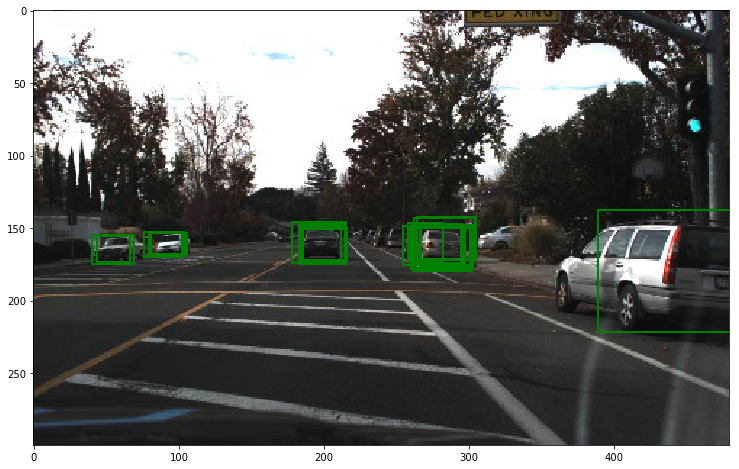

In [193]:
plt.figure(figsize=(16,8))
plt.imshow(X[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    current_axis.add_patch(plt.Rectangle((box[0], box[2]), box[1]-box[0], box[3]-box[2], color='green', fill=False, linewidth=2))

In [19]:
arr = np.random.randint(10, size=(2,3,2))
arr2 = np.random.randint(10, size=(2,3,3))
print("arr:", arr)
ind = np.random.randint(1, size=(2,3,2))

i0, i1, i2 = np.indices(arr.shape)
print(i0.shape)

newarr = arr[i0,i1,ind]

print("newarr:", newarr)

arr: [[[6 5]
  [4 1]
  [1 8]]

 [[0 7]
  [9 9]
  [1 1]]]
(2, 3, 2)
newarr: [[[6 6]
  [4 4]
  [1 1]]

 [[0 0]
  [9 9]
  [1 1]]]


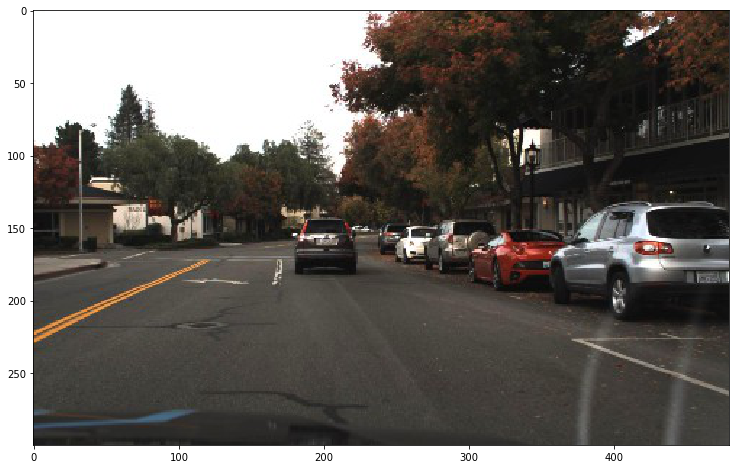

In [14]:
from matplotlib import pyplot as plt
from matplotlib import image as mpimg

%matplotlib inline

img = mpimg.imread("./data/1478900910256548477.jpg")

plt.figure(figsize=(16,8))
plt.imshow(img)